In [157]:
import numpy as np
import matplotlib.pyplot as plt
import random
try:
    import importlib
    importlib.reload(h)
    importlib.reload(f)
    importlib.reload(d)
except NameError: # It hasn't been imported yet
    import helpers as h
    import implementations as f
    import data_processing as d

# Data preprocessing and feature selections

## Data preprocessing

#For this to work, the data folder needs to be one level above the project folder and the folder name needs
#to be 'data'
data_folder = '../data/'
x_train, x_test, y_train, train_ids, test_ids = h.load_csv_data(data_folder)


In [2]:
np.random.seed(0)

x_train, x_test, y_train, train_ids, test_ids = h.load_csv_data("../data")

np.save('../data/y_train.npy', y_train)
np.save('../data/x_train.npy', x_train)
np.save('../data/x_test.npy', x_test)
np.save('../data/train_ids.npy', train_ids)
np.save('../data/test_ids.npy', test_ids)

In [39]:
x_train = np.load("../data/x_train.npy")
x_test = np.load("../data/x_test.npy")
y_train = np.load("../data/y_train.npy")
train_ids = np.load("../data/train_ids.npy")
test_ids = np.load("../data/test_ids.npy")

In [40]:
#features_named all the features names and remove the ID column
features_name = np.genfromtxt('../data/x_train.csv', delimiter=',', dtype=str, max_rows=1)[1:] 
features_name

array(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'CTELENUM', 'PVTRESD1', 'COLGHOUS', 'STATERES',
       'CELLFON3', 'LADULT', 'NUMADULT', 'NUMMEN', 'NUMWOMEN', 'CTELNUM1',
       'CELLFON2', 'CADULT', 'PVTRESD2', 'CCLGHOUS', 'CSTATE', 'LANDLINE',
       'HHADULT', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH',
       'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BPMEDS',
       'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW',
       'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2',
       'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', 'MARITAL', 'EDUCA',
       'RENTHOM1', 'NUMHHOL2', 'NUMPHON2', 'CPDEMO1', 'VETERAN3',
       'EMPLOY1', 'CHILDREN', 'INCOME2', 'INTERNET', 'WEIGHT2', 'HEIGHT3',
       'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK',
       'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'STOPSMK2',
       'LASTSMK2', 'USENOW3', 'ALCDAY5', 'AVEDRNK2', 'DRNK3GE5',
    

## Feature selection

one paper on internet suggests to use these features : 

 _RFHYPE5, TOLDHI2, _CHOLCHK, _BMI5, SMOKE100, CVDSTRK3, DIABETE3, _TOTINDA, _FRTLT1, _VEGLT1, _RFDRHV5, HLTHPLN1, MEDCOST, GENHLTH, MENTHLTH, PHYSHLTH, DIFFWALK, SEX, _AGEG5YR, EDUCA, and INCOME2

We apply a mask to get only these important features.

Then using we use our preprocessing function. For feature where the answer is yes or no we make the data binary, ordinal (categorical) variables ares changed to 0,1,2,...,Missing values are replace by the mean of the column.


In [41]:
#Select the important features
features_list = ['_RFHYPE5', 'TOLDHI2', '_CHOLCHK', '_BMI5', 'SMOKE100', 'CVDSTRK3', 'DIABETE3', '_TOTINDA', '_FRTLT1', '_VEGLT1', '_RFDRHV5', 
                 'HLTHPLN1', 'MEDCOST', 'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK', 'SEX', '_AGEG5YR', 'EDUCA', 'INCOME2']


# Processing [Necessary] 
### We want to clean the data for each feature, making them binary for yes/no, etc... and rename them

In [42]:
X = [x_train, x_test]
print(x_train.shape)

for i,x in enumerate(X): 
    x = d.masking(x, features_name,features_list)
    x = d.feature_processing_test(x)
    x = d.replace_nan_mean_column(x)
    X[i] = x


x_train_algo, x_test_algo = X[0], X[1]

(328135, 321)


In [12]:
trainMask, testMask = d.masking((x_train, x_test), features_list)
trainProcessed = d.feature_processing_test(trainMask)

#Test data Processing 
testProcessed  = d.feature_processing_test(testMask)

x_train_algo = f.replaceMissingValuesMean(trainProcessed)
x_test_algo = f.replaceMissingValuesMean(testProcessed)
print(x_train_algo[:,19])
print(len(x_train_algo))
print(len(features_list))


NameError: name 'masking' is not defined

In [166]:
##test chelou
#x1_stand=f.standardize(x_train_algo)
x_train_stand=np.ones(x_train_algo.shape)
x_test_stand=np.ones(x_test_algo.shape)

x_trai_stand=f.standardize(x_train_algo)

for i in range(len(features_list)):
  x_train_stand[i]=f.standardize(x_train_algo[i])
  x_test_stand[i]=f.standardize(x_test_algo[i])

print(x_trai_stand==x_train_stand)



[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


### Now that the preprocessing has been done, we can format the data to be used by the algorithms

In [44]:
tX_train = np.c_[np.ones((len(x_train_algo), 1)), x_train_algo]
tX_test = np.c_[np.ones((len(x_test_algo), 1)), x_test_algo]

#tX_train = np.c_[np.ones((len(x_train_algo), 1)), x_train_stand]
#tX_test = np.c_[np.ones((len(x_test_algo), 1)), x_test_stand]

### Initialisation of set parameters

In [45]:
initial_w = [random.choice([1, -1]) for i in range(len(tX_train[0]))]
max_iter = 500

### Separation of the dataset in a test/train set

In [46]:
tX_train_train = tX_train[:int(len(tX_train)*0.7)]
y_train_train = y_train[:int(len(tX_train)*0.7)]
tX_train_test = tX_train[int(len(tX_train)*0.7):]
y_train_test = y_train[int(len(tX_train)*0.7):]



## Plotting functions

In [176]:
def plotLossMSE(weights, loss, y, x ):
    loss_test_set = []

    for w in weights:
        loss_test_set.append(f.compute_mse(y, x, w))

    plt.figure(0)
    plt.semilogy(loss, label = "intial_loss")
    plt.semilogy(loss_test_set, label = "test_loss")
    plt.legend()
    plt.show()

## And then, we can run the algorithms

1. MSE gradient descent

We try several weights for gamma to see which one is the best

Gradient Descent(199/200): Final loss=1.5583404219624488
0.002000: 1.558340
Gradient Descent(199/200): Final loss=1.0938345073741935
0.004000: 1.093835
Gradient Descent(199/200): Final loss=0.858779034941902
0.006000: 0.858779
Gradient Descent(199/200): Final loss=0.7226242299106065
0.008000: 0.722624
Gradient Descent(199/200): Final loss=0.6329712673085639
0.010000: 0.632971
Gradient Descent(10/200): Final loss=12581.300861055412
0.012000: 0.000000
Gradient Descent(4/200): Final loss=10336.75896259267
0.014000: 0.000000


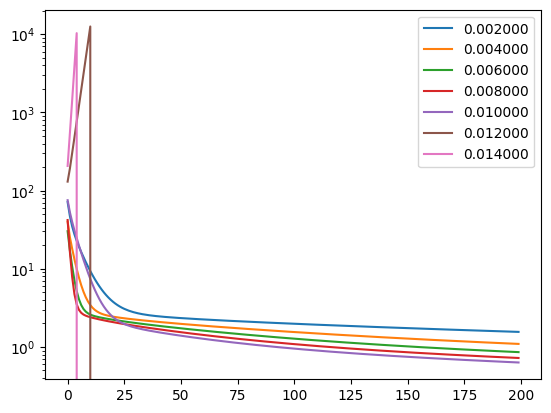

In [71]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = np.arange(0.002, 0.016, 0.002)
for g in gamma:
    w, loss = f.mean_squared_error_gd(y_train_train, tX_train_train, initial_w, 200, g)
    print("%f: %f" % (g, loss[-1]))
    plt.semilogy(loss, label = "%f" % g)


plt.legend()
plt.show()


It semes the best one is gamma = 0.01, we'll then use this one 

In [72]:
w_mse_gd, loss_mse_gd = f.mean_squared_error_gd(y_train_train, tX_train_train, initial_w, 2000, 0.01)

Gradient Descent(1999/2000): Final loss=0.15387586602807266


We compare the progression of the loss on the test set, in order to ensure there's no overfitting with the increasing amount of iteration

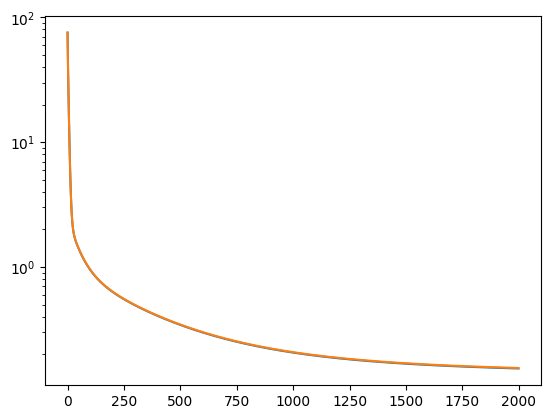

In [73]:
plotLossMSE(w_mse_gd, loss_mse_gd, y_train_test, tX_train_test)

In [74]:
y_pred = tX_train_test.dot(w_mse_gd[-1])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))
print("F1 score: ", f1)


Accuracy:  0.9100374843815077
F1 score:  0.1775631500742942


In [75]:
#Apply the model to the test sample

y_test = tX_test.dot(w_mse_gd[-1])
y_test_rounded = np.where(y_test > 0, 1, -1) #not sure about this line

print('weights = \n\n', w_mse_gd[-1],'\n\n Loss = ', loss_mse_gd[-1],'\n\n*****************************************************************************',
      ' \n\n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded == 1)/len(y_test_rounded))

weights = 

 [-1.00301408e+00  7.54774518e-02  3.37162367e-03 -5.69674609e-04
 -3.48816346e-01 -2.86456369e-01 -1.18767130e-01 -6.78592990e-01
 -1.40933101e-02 -6.93936391e-02  4.44519798e-03 -3.68482618e-03
  1.37062395e-01 -8.21372095e-02  2.46306865e-02  1.41343224e-01
  2.14581949e-02  9.27599850e-01  4.26151670e-01  1.17901221e-02
  6.92345542e-02 -4.95885145e-02] 

 Loss =  0.15387586602807266 

*****************************************************************************  

 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.02032382815714168


In [ ]:
#h.create_csv_submission(test_ids, y_test_rounded, 'submission_gd.csv')

Lets run some cross validation to see the best initial weights (as a function of the proportion of 1, -1 and 0)


2. MSE SGD

SGD iter. 999/999: loss=0.6211807312640275, w0=-1.0552753965839645, w1=0.7395794857754598
0.000100: 0.621181
SGD iter. 999/999: loss=0.0006693901586718166, w0=-1.0360432769752603, w1=0.7130037578466748
0.000200: 0.000669
SGD iter. 999/999: loss=1.3515706497571396, w0=-1.0335033089676444, w1=0.6320838995663334
0.000300: 1.351571
SGD iter. 999/999: loss=0.8562557724695149, w0=-1.0334714391092263, w1=0.5816665883706582
0.000400: 0.856256
SGD iter. 999/999: loss=1.408391561226846, w0=-1.026587518458656, w1=0.5868579013491245
0.000500: 1.408392
SGD iter. 999/999: loss=0.26463847271346036, w0=-1.012747248588496, w1=0.5487130684821139
0.000600: 0.264638
SGD iter. 999/999: loss=0.5365672688380083, w0=-1.0157023931236941, w1=0.6136371272141143
0.000700: 0.536567
SGD iter. 999/999: loss=5.245434175552511, w0=-1.0268264931489923, w1=0.48905896984771147
0.000800: 5.245434
SGD iter. 999/999: loss=0.0674732214029878, w0=-1.0364457756183154, w1=0.4346552142993084
0.000900: 0.067473
SGD iter. 999/999:

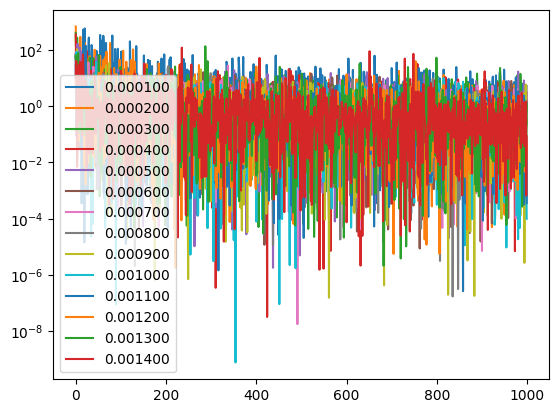

In [82]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = np.arange(0.0001, 0.0015, 0.0001)
g_opti = gamma[0]
loss_opti = 1000
for g in gamma:
    w, loss = f.mean_squared_error_sgd(y_train_train, tX_train_train, initial_w, 1000, g)
    mean_loss = np.mean(loss[-100:])
    if mean_loss < loss_opti:
        loss_opti = mean_loss
        g_opti = g
    print("%f: %f" % (g, loss[-1]))
    plt.semilogy(loss, label = "%f" % g)

print("optimal gamma: ", g_opti)
plt.legend()
plt.show()


In [83]:
w_mse_sgd, loss_mse_sgd = f.mean_squared_error_sgd(y_train_train, tX_train_train, initial_w, 3000, 0.0012)

SGD iter. 2999/2999: loss=0.3012038422680951, w0=-1.0286211101384353, w1=0.08055747622618244


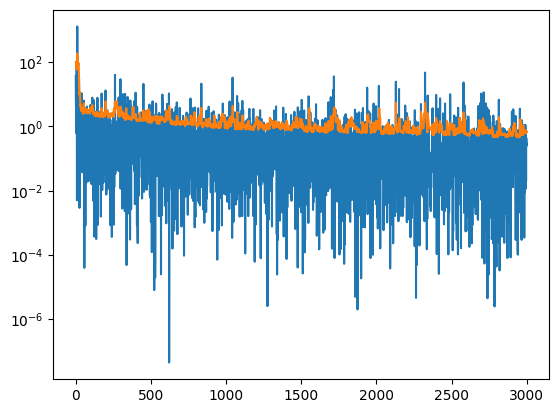

In [84]:
plotLossMSE(w_mse_sgd, loss_mse_sgd, y_train_test, tX_train_test)

In [85]:
y_pred = tX_train_test.dot(w_mse_sgd[-1])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.7313416157901688
F1 score:  0.23737708699789498


In [87]:
y_test_sgd = tX_test.dot(w_mse_sgd[-1])
y_test_rounded_sgd = np.where(y_test_sgd > 0, 1, -1)

print('weights = \n', w_mse_sgd[-1],'\n Loss = ', loss_mse_sgd[-1],'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded_sgd == 1)/len(y_test_rounded_sgd))

weights = 
 [-1.02862111  0.08055748  0.08458398 -0.06264826 -0.77752054 -0.8301922
 -0.61607455 -0.937387   -0.21372078  0.51504098 -0.08086763 -0.0059737
  0.74422312 -0.51182643  0.66208016  0.66167939  0.03600852  0.96047636
  0.81645565  0.41650504  0.5530287  -0.6564092 ] 
 Loss =  0.3012038422680951 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.26052532935938344


3. Least squares

In [88]:
w_ls, loss_ls = f.least_squares(y_train_train, tX_train_train)

In [89]:
y_pred = tX_train_test.dot(w_ls)
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.9117034568929613
F1 score:  0.03529411764705882


In [90]:

y_test_ls = tX_test.dot(w_ls)
y_test_ls = np.where(y_test_ls > 0, 1, -1)

print('weights = \n', w_ls,'\n Loss = ', loss_ls,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ls == 1)/len(y_test_ls))

weights = 
 [-3.54515184e-01  5.76100349e-02  2.15645760e-03 -1.88754185e-04
 -3.22325550e-02 -9.15316093e-03 -9.19649704e-02 -3.69989496e-01
 -4.77401102e-02 -9.79382213e-02 -2.50199111e-03 -5.79831694e-03
 -1.02170381e-01 -4.18711437e-02 -7.19620069e-02  3.78987972e-02
  1.72309041e-02 -2.14401256e-01  2.99498822e-02 -5.64090919e-03
 -5.15795614e-03 -9.86993155e-03] 
 Loss =  0.1368442031431572 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.0025873339489298677


4. Ridge regression

In [144]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = np.arange(5*10**(-7), 5*10**(-6), 1*10**(-7))
#gamma = [44,12,3, 0.1, 5*10**(-7)]
g_opti = gamma[0]
loss_opti = 1000
for g in gamma:
    w_ridge, loss_ridge = f.ridge_regression(y_train, tX_train, g)
    if loss_ridge < loss_opti:
        loss_opti = loss_ridge
        g_opti = g
    print("%e: %f" % (g, loss_ridge))
    #plt.semilogy(loss_ridge, label = "%f" % g)

print("optimal gamma: %.e " % g_opti)
#plt.legend()
#plt.show()


5.000000e-07: 0.137313
6.000000e-07: 0.137313
7.000000e-07: 0.137313
8.000000e-07: 0.137313
9.000000e-07: 0.137313
1.000000e-06: 0.137313
1.100000e-06: 0.137313
1.200000e-06: 0.137313
1.300000e-06: 0.137313
1.400000e-06: 0.137313
1.500000e-06: 0.137313
1.600000e-06: 0.137313
1.700000e-06: 0.137313
1.800000e-06: 0.137313
1.900000e-06: 0.137313
2.000000e-06: 0.137313
2.100000e-06: 0.137313
2.200000e-06: 0.137313
2.300000e-06: 0.137313
2.400000e-06: 0.137313
2.500000e-06: 0.137313
2.600000e-06: 0.137313
2.700000e-06: 0.137313
2.800000e-06: 0.137313
2.900000e-06: 0.137313
3.000000e-06: 0.137313
3.100000e-06: 0.137313
3.200000e-06: 0.137313
3.300000e-06: 0.137313
3.400000e-06: 0.137313
3.500000e-06: 0.137313
3.600000e-06: 0.137313
3.700000e-06: 0.137313
3.800000e-06: 0.137313
3.900000e-06: 0.137313
4.000000e-06: 0.137313
4.100000e-06: 0.137313
4.200000e-06: 0.137313
4.300000e-06: 0.137313
4.400000e-06: 0.137313
4.500000e-06: 0.137313
4.600000e-06: 0.137313
4.700000e-06: 0.137313
4.800000e-0

In [147]:
w_ridge, loss_ridge = f.ridge_regression(y_train, tX_train, g_opti)

In [148]:
y_pred = tX_train_test.dot(w_ridge)
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.9117339319998781
F1 score:  0.03658942233063533


In [149]:
y_test_ridge = tX_test.dot(w_ridge)
y_test_ridge = np.where(y_test_ridge > 0, 1, -1)

print('weights = \n', w_ridge,'\n Loss = ', loss_ridge,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ridge == 1)/len(y_test_ridge))

weights = 
 [-3.56072918e-01  5.74373901e-02  2.26652676e-03 -2.17115747e-04
 -3.02792252e-02 -7.34101852e-03 -9.04437065e-02 -3.74132400e-01
 -4.82611073e-02 -9.90399010e-02 -1.69204890e-03 -5.60281829e-03
 -9.93494066e-02 -4.22235181e-02 -7.38682594e-02  3.63732922e-02
  1.71957691e-02 -2.22526245e-01  3.23445120e-02 -6.39351877e-03
 -4.69298361e-03 -7.48525588e-03] 
 Loss =  0.13731317796536324 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.002687901699594986


5. Logistic regression

In [152]:
y_train_processed_logreg = np.where(y_train == 1, 1, 0)
y_train_train_lg = np.where(y_train == 1, 1, 0)
initial_w = [random.choice([1, 0]) for i in range(len(tX_train[0]))]

Gradient Descent(99/99): loss=0.30219161238772, w0=-0.3045858556562981, w1=-0.2611936223310911
1.000000e-01: 0.302192
Gradient Descent(99/99): loss=0.29655136153023065, w0=-0.31221452691765894, w1=-0.23981295982693088
1.100000e-01: 0.296551
Gradient Descent(99/99): loss=0.30977328438982854, w0=-0.31517980869909645, w1=-0.2086455880089817
1.200000e-01: 0.309773
Gradient Descent(99/99): loss=0.3497583795792655, w0=-0.32665796370621913, w1=-0.2076523650467598
1.300000e-01: 0.349758
Gradient Descent(99/99): loss=0.39972544744608224, w0=-0.3332991628878237, w1=-0.19336100382513183
1.400000e-01: 0.399725
Gradient Descent(99/99): loss=0.33945753461235123, w0=-0.32858360148286847, w1=-0.139327761951402
1.500000e-01: 0.339458
Gradient Descent(99/99): loss=0.2833752039507024, w0=-0.33601605168212406, w1=-0.12784077901836766
1.600000e-01: 0.283375
Gradient Descent(99/99): loss=0.2879643142792445, w0=-0.3416449563772985, w1=-0.10485670706586424
1.700000e-01: 0.287964
Gradient Descent(99/99): loss=

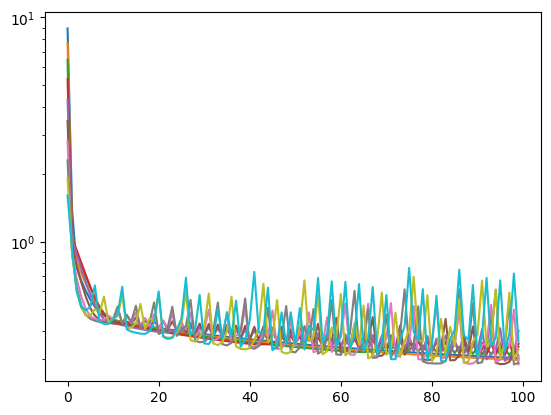

In [167]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = np.arange(10*10**(-2), 20*10**(-2), 1*10**(-2))
#gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
g_opti = gamma[0]
loss_opti = 1000
for g in gamma:
    w_logreg, loss_logreg = f.logistic_regression(y_train_train_lg, tX_train, initial_w, 100, g)
    if loss_logreg[-1] < loss_opti:
        loss_opti = loss_logreg[-1]
        g_opti = g
    print("%e: %f" % (g, loss_logreg[-1]))
    plt.semilogy(loss_logreg, label = "%f" % g)

print("optimal gamma: %e " % g_opti)
#plt.legend()
#plt.show()

In [168]:
w_logreg, loss_logreg = f.logistic_regression(y_train_train_lg, tX_train,np.ones(22),500, g_opti)

Gradient Descent(499/499): loss=0.26008882864538263, w0=-0.06084870760045689, w1=0.07833570606488625


In [188]:
def plotLossLOGREG(weights, loss, y, x ):
    loss_test_set = []

    for w in weights:
        loss_test_set.append(f.compute_loss_logistic(y, x, w))
        print(loss_test_set[-1])

    plt.figure(0)
    plt.plot(loss, label = "initial_loss")
    plt.plot(loss_test_set, label = "test_loss")
    plt.legend()
    plt.show()

29.29791739401477
-4.3222999452800135
-4.077035584605081
-3.796633294070535
-3.6159883245354534
-3.485343856482638
-3.3556444930267935
-3.232058029589628
-3.1139307425880647
-3.00926815770916
-2.9192240878443494
-2.847074465716935
-2.7911234691689515
-2.7509577892477255
-2.723087924787554
-2.705884890455046
-2.695908579179493
-2.6919759279981164
-2.69143663383222
-2.6939510917043314
-2.6975309749674343
-2.702547082245255
-2.7073259017622227
-2.7127941092874046
-2.717278694792476
-2.722227800296529
-2.725690487896317
-2.7297395595449783
-2.7318354388750037
-2.734938970238507
-2.7354849031149158
-2.7378189042506813
-2.7366459845143094
-2.7385886996886453
-2.735405437141796
-2.73760803618251
-2.731812373694235
-2.7353997445127756
-2.7257456841525673
-2.7327599041879465
-2.7166949278583816
-2.731042496726102
-2.703321802900108
-2.7328180267153623
-2.6825213079268595
-2.743394074768441
-2.647396244887879
-2.7743830540872483
-2.583183969369111
-2.8518952410678198
-2.462032529001609
-3.030341

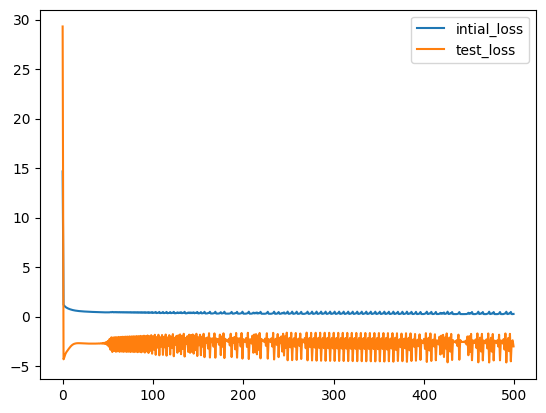

In [189]:
plotLossLOGREG(w_logreg, loss_logreg, y_train_test, tX_train_test)

In [179]:
y_pred = tX_train_test.dot(w_logreg[-1])
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.where(y_pred == 1, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.9109111041131236
F1 score:  0.007244736246321032


In [182]:
y_test_logreg = tX_test.dot(w_logreg[-1])
y_test_logreg = np.where(y_test_logreg > 0.5, 1, 0)

print('weights = \n', w_logreg[-1],'\n Loss = ', loss_logreg[-1],'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train== 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_logreg == 1)/len(y_test_logreg))

weights = 
 [-0.06084871  0.07833571 -0.0219387  -0.02134484  0.40003391  0.06960065
 -0.53364242 -0.59082148 -0.47502708 -0.53921583 -0.33005558 -0.1266862
 -0.34462139 -0.28933262 -0.56421488  0.48794772  0.11810916  0.67429313
 -0.0271953   0.02045846  0.14548875  0.13458863] 
 Loss =  0.26008882864538263 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.000740544345806782


In [117]:
w_reg_logreg, loss_reg_logreg = f.reg_logistic_regression(y_train_processed_logreg, tX_train, 0.01, initial_w, 100, 0.1)

Gradient Descent(0/99): loss=18.207806990644862, w0=0.9078319282799385, w1=0.9078341834706829
Gradient Descent(1/99): loss=16.36117617190301, w0=0.8157561433011598, w1=0.815760581290357
Gradient Descent(2/99): loss=14.516392331053625, w0=0.7237725585933471, w1=0.7237791043345082
Gradient Descent(3/99): loss=12.67345441132835, w0=0.631881095434813, w1=0.6318896713945503
Gradient Descent(4/99): loss=10.832366467881576, w0=0.5400817347412534, w1=0.5400922610999396
Gradient Descent(5/99): loss=8.99317095889692, w0=0.4483749079165405, w1=0.44838730280129574
Gradient Descent(6/99): loss=7.156198218760744, w0=0.35676443230285565, w1=0.35677861205126216
Gradient Descent(7/99): loss=5.323926978543616, w0=0.26527949655879657, w1=0.26529537601322084
Gradient Descent(8/99): loss=3.5145487817161682, w0=0.17413819403247968, w1=0.17415568688197136
Gradient Descent(9/99): loss=1.8472306256148947, w0=0.0849185676753477, w1=0.0849375869953934
Gradient Descent(10/99): loss=0.76013464705722, w0=0.00703401

In [118]:
y_test_reg_logreg = tX_test.dot(w_reg_logreg)
y_test_reg_logreg = np.where(y_test_reg_logreg > 0.5, 1, 0)

print('weights = \n', w_reg_logreg,'\n Loss = ', loss_reg_logreg,'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_reg_logreg == 1)/len(y_test_reg_logreg))


weights = 
 [-0.10570318 -0.10557408 -0.10551638 -0.10546428 -0.10539099 -0.10547108
 -0.10545289 -0.10547108 -0.10555219 -0.10543358 -0.10580189 -0.10591579
 -0.10548113 -0.10543551 -0.10544656 -0.10545656 -0.10594989 -0.10540836
 -0.10546825 -0.10540809 -0.10538928 -0.10540574] 
 Loss =  0.2986065187306014 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.0


In [147]:
y_sub = np.where(y_test_reg_logreg == 1, 1, -1)
h.create_csv_submission(test_ids, y_sub, 'submission_reg_logreg6.csv')